In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
# from scipy.integrate import trapezoid as trapz
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle


from dask.diagnostics import ProgressBar


import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [ ]:
varf

In [2]:
# def SMfield(var,g_sigma=None,time_str='dayofyear'):
#     from scipy.ndimage import gaussian_filter as gauss
#     var_smoothed=var.copy()
    
#     for ix in range(var[time_str].shape[0]):
#         var_smoothed[ix]=gauss(var[ix].data,g_sigma)
    
#     var_prime=var-var_smoothed
#     return var_smoothed,var_prime



In [3]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [4]:
plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.weight']='bold'

In [12]:
dxx=0.5
dyy=dxx

In [6]:
chunks_new={'dayofyear':40}
tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);

In [7]:
sns.set_style("darkgrid")

In [8]:
%%time
chunks_new={'dayofyear':40}

tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,1:-1,1:-1]
tf=tf[:,120:-120,120:800].compute();

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,1:-1,1:-1]
tt=tt[:,120:-120,120:800].compute();



CPU times: user 33.1 s, sys: 12.2 s, total: 45.2 s
Wall time: 7.01 s


In [9]:
%%time
chunks_new={'dayofyear':40}

hf=-varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
hf=hf[:,1:-1,1:-1]
hf=hf[:,120:-120,120:800].compute();

ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
ht=ht.chunk(chunks=chunks_new);
ht=ht[:,1:-1,1:-1]
ht=ht[:,120:-120,120:800].compute();

CPU times: user 32.6 s, sys: 11 s, total: 43.7 s
Wall time: 14.8 s


In [10]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())

##### Filtering data and testing in the spectra

In [11]:
# %time 
# disk = xr.DataArray(disk, dims=['kx', 'ky']) 
# tf[1].rolling(x_rho=81,y_rho=81).construct(x_rho='kx', y_rho='ky').dot(disk).plot()

In [12]:
# def xTopHat(data,lowcut=40,highcut=1):
# %%time

# lowcut=40
# y,x = np.ogrid[-lowcut: lowcut+1, -lowcut: lowcut+1]
# disklow = x**2+y**2 <= lowcut**2
# disklow = disklow.astype(float)
# disklow = disklow/sum(sum(disklow))

# DiskLow = xr.DataArray(disklow, dims=['kx', 'ky'])

# lfilt=tf.rolling(x_rho=disklow.shape[0],y_rho=disklow.shape[1]).construct(x_rho='kx', y_rho='ky').dot(DiskLow)


In [13]:
def tophat_bandpass_2d(data,lowcut=40,highcut=1):
    from scipy.signal import convolve2d
    BandFilt=data.copy()
    
    for idd in range(data.shape[0]):
        lowcut= int(np.round(lowcut))

        y,x = np.ogrid[-lowcut: lowcut+1, -lowcut: lowcut+1]
        disklow = x**2+y**2 <= lowcut**2
        disklow = disklow.astype(float)
        disklow = disklow/sum(sum(disklow))
        # DiskLow = xr.DataArray(disklow, dims=['kx', 'ky']) 
        
        # convolute the fields with the kernel
        lowfiltered = convolve2d(data[idd],disklow, mode='same', boundary='fill', fillvalue=0)
        
        # LowFilt=data.copy()
        # LowFilt[idd].data=lowfiltered
        # LowPrime=data[idd]-LowFilt
        lowprime=data[idd]-lowfiltered

        highcut= int(np.round(highcut))

        y,x = np.ogrid[-highcut: highcut+1, -highcut: highcut+1]
        diskhigh = x**2+y**2 <= highcut**2
        diskhigh = diskhigh.astype(float)
        diskhigh = diskhigh/sum(sum(diskhigh))

        # convolute the fields with the kernel
        # bandfiltered = convolve2d(LowPrime,diskhigh, mode='same', boundary='fill', fillvalue=0)
        bandfiltered = convolve2d(lowprime,diskhigh, mode='same', boundary='fill', fillvalue=0)

        # BandFilt=data.copy()
        BandFilt[idd]=bandfiltered
        
        
    return BandFilt

In [14]:
# %%time
# radius= 40
# y,x = np.ogrid[-radius: radius+1, -radius: radius+1]
# disk = x**2+y**2 <= radius**2
# disk = disk.astype(float)
# disk = disk/sum(sum(disk))
# # convolute the fields with the kernel
# um = convolve2d(tf[0],disk, mode='same', boundary='fill', fillvalue=0)

# um=tophat_bandpass_2d(tf[:1],lowcut=40,highcut=1)
# um=tophat_bandpass_2d(tf[::3],lowcut=40,highcut=1)

In [15]:
# filt=tf[0].copy()
# filt.data=um
# prim=tf[0]-filt


In [51]:
# radius= 1
# y,x = np.ogrid[-radius: radius+1, -radius: radius+1]
# disk = x**2+y**2 <= radius**2
# disk = disk.astype(float)
# disk = disk/sum(sum(disk))

# bprim=convolve2d(prim,disk, mode='same', boundary='fill', fillvalue=0)
# band=tf[0].copy()
# band.data=bprim

In [112]:

# xlim=100
# asp=xrft.isotropic_power_spectrum(tf[0,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
# # bsp=xrft.isotropic_power_spectrum(lfilt[xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
# # csp=xrft.isotropic_power_spectrum(prim[xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)
# dsp=xrft.isotropic_power_spectrum(um[0,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),nfactor=2,truncate='True',detrend='linear', window=True)




# plt.figure(figsize=(10,8))
# plt.plot([1/40,1/40],[1e-12,1],'k--')
# plt.plot([1/4,1/4],[1e-12,1],'k--')


# # plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

# plt.title('Filter test example')

# plt.plot(asp.freq_r/dxx,asp,label=r'T$_{FULL}$')
# # plt.plot(bsp.freq_r/dxx,bsp,color='green',label=r'$\overline{T}_{FULL}$ (40km filter)')
# # plt.plot(csp.freq_r/dxx,csp,color='orange',label=r'$T\prime_{FULL}$ (40km filter)')
# plt.plot(dsp.freq_r/dxx,dsp,color='pink',label=r'$T^*_{FULL}$ (40-4km filter)')



# plt.legend()

# plt.yscale('log')
# plt.xscale('log')

# plt.ylim(1e-12,1)
# plt.tight_layout()

In [25]:
# def butter_bandpass(lowcut, highcut, fs, order=5):
#     return signal.butter(order, [lowcut, highcut], fs=fs, btype='band')

# def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = signal.lfilter(b, a, data) #errado
#     return y

In [208]:

# gnum=4.5
dec=10
# sst_fg,sst_fp=SMfield(tf,g_sigma=gnum,time_str='dayofyear')
# sst_tg,sst_tp=SMfield(tt,g_sigma=gnum,time_str='dayofyear')

# h_fg,h_fp=SMfield(hf,g_sigma=gnum,time_str='dayofyear')
# h_tg,h_tp=SMfield(ht,g_sigma=gnum,time_str='dayofyear')



tf_band=tophat_bandpass_2d(tf[::dec],lowcut=45,highcut=1)
# tt_band=tophat_bandpass_2d(tt[::dec],lowcut=45,highcut=1)

hf_band=tophat_bandpass_2d(hf[::dec],lowcut=45,highcut=1)
# ht_band=tophat_bandpass_2d(ht[::dec],lowcut=45,highcut=1)



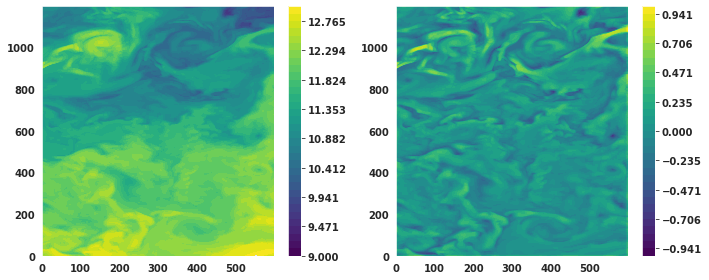

In [214]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(tf[0,xlim:-xlim,xlim:-xlim],cmap='viridis',levels=np.linspace(9,13,35))
plt.colorbar()


plt.subplot(1,2,2)
plt.contourf(tf_band[0,xlim:-xlim,xlim:-xlim],cmap='viridis',levels=np.linspace(-1,1,35))
plt.colorbar()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/maps_filter_test_tophat.png')



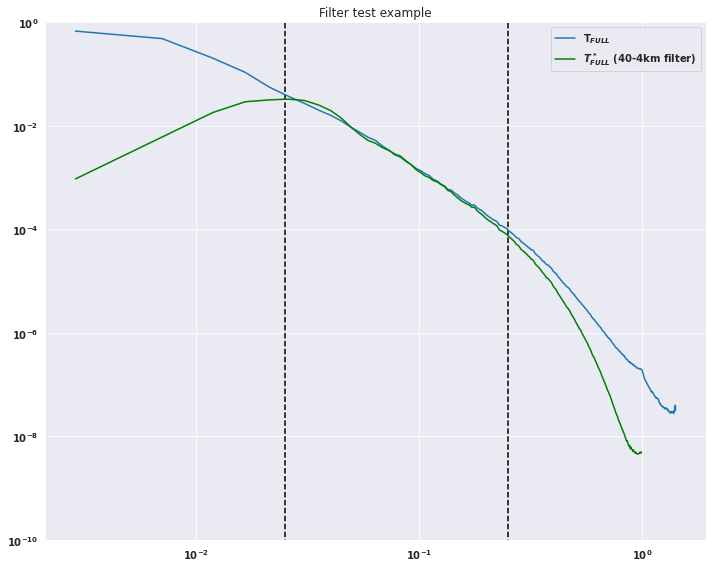

In [211]:
xlim=40
asp=xrft.isotropic_power_spectrum(tf[::dec,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),dim=['x_rho','y_rho'],nfactor=2,dimtruncate='True',detrend='linear', window=True)
bsp=xrft.isotropic_power_spectrum(tf_band[:,xlim:-xlim,xlim:-xlim].drop(['nav_lat_rho', 'nav_lon_rho']),dim=['x_rho','y_rho'],nfactor=2,truncate='True',detrend='linear', window=True)




plt.figure(figsize=(10,8))
plt.plot([1/40,1/40],[1e-12,1],'k--')
plt.plot([1/4,1/4],[1e-12,1],'k--')


# plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

plt.title('Filter test example')
plt.plot(asp.freq_r/dxx,asp.mean(axis=0),label=r'T$_{FULL}$')
plt.plot(bsp.freq_r/dxx,bsp.mean(axis=0),color='green',label=r'$T^*_{FULL}$ (40-4km filter)')




plt.legend()

plt.yscale('log')
plt.xscale('log')

plt.ylim(1e-10,1)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/filter_test_tophat.png')


In [215]:
ddec=10
reg_f=pd.DataFrame({'HFX':np.ravel(hf_band[:,xlim:-xlim,xlim:-xlim])[::ddec],'SST':np.ravel(tf_band[:,xlim:-xlim,xlim:-xlim])[::ddec]})
# reg_fbar=pd.DataFrame({'HFX':np.ravel(h_fg)[::100],'SST':np.ravel(sst_fg)[::100]})



In [216]:
Rsq=np.zeros([hf_band.shape[0]])*np.nan;

for icc in range(Rsq.shape[0]):
    Rsq[icc]=np.corrcoef(np.ravel(hf_band[icc,xlim:-xlim,xlim:-xlim]),np.ravel(tf_band[icc,xlim:-xlim,xlim:-xlim]))[0][1]
    # Rsqm[icc]=np.corrcoef(np.ravel(r[icc]),np.ravel(h_fg[icc]))[0][1]


In [229]:
np.corrcoef(reg_f.SST,reg_f.HFX)[0][1]

0.4294596984424112

In [217]:
np.nanmean(Rsq)

0.4407886730155081

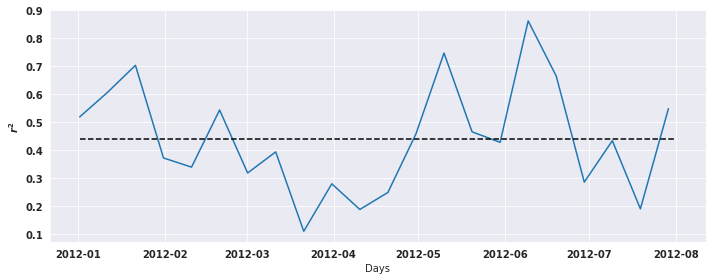

In [219]:
plt.figure(figsize=(10,4))

plt.plot(timer[::dec],Rsq)
plt.plot(timer,np.nanmean(Rsq)+np.zeros(timer.shape),'k--',color='black')
plt.ylabel(r'$r^{2}$')
plt.xlabel('Days')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/correlation_timeseries_tophat.png')




In [220]:
apoly=np.zeros(hf_band.shape[0])*np.nan;
bpoly=np.zeros(hf_band.shape[0])*np.nan;
for ide in range(hf_band.shape[0]):
    decx=1
    regg=pd.DataFrame({'HFX':np.ravel(hf_band[ide,xlim:-xlim,xlim:-xlim])[::decx],'SST':np.ravel(tf_band[ide,xlim:-xlim,xlim:-xlim])[::decx]})
    apoly[ide],bpoly[ide]=np.polyfit(regg.SST,regg.HFX,deg=1)



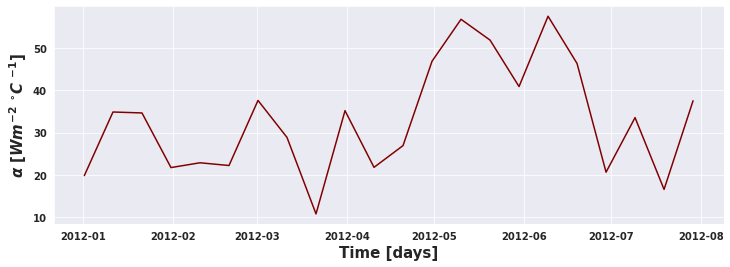

In [222]:

plt.figure(figsize=(12,4))
plt.plot(timer[::dec],apoly,color='maroon')
plt.xlabel('Time [days]',fontsize=15,fontweight='bold')
plt.ylabel(r'$\alpha$ $[W m^{-2}$ $^{\circ}C$ $^{-1}]$',fontsize=15,fontweight='bold')
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/slope_timeseries_tophat.png')





In [223]:
aa,bb=np.polyfit(reg_f.SST,reg_f.HFX,deg=1)

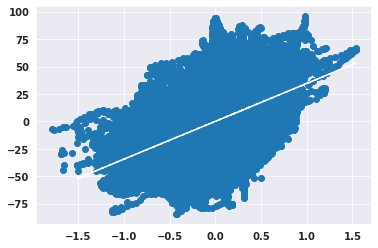

In [224]:
plt.scatter(reg_f.SST,reg_f.HFX)
plt.plot(reg_f.SST[::10],(aa*reg_f.SST)[::10],'w--',alpha=1)

In [234]:
aa

34.50390856625349

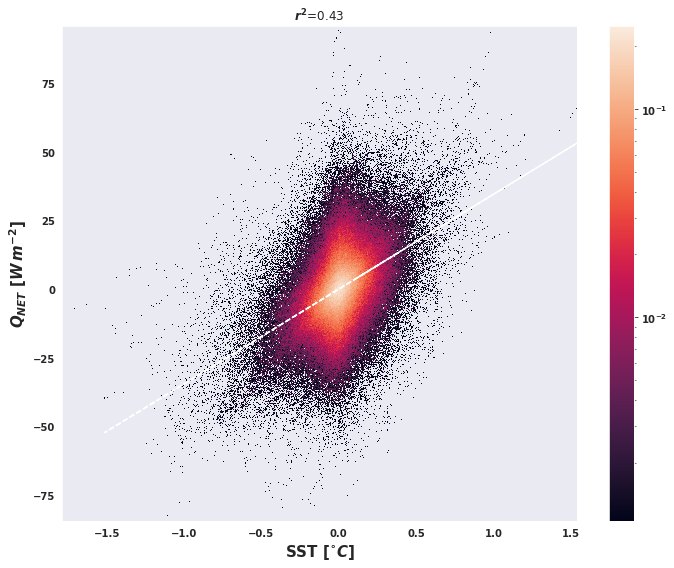

In [235]:
import matplotlib as mpl


plt.figure(figsize=(10,8))
plt.hist2d(reg_f.SST,reg_f.HFX,bins=1000,density=True,norm=mpl.colors.LogNorm())
# plt.hist2d(reg_fbar.SST,reg_fbar.HFX,bins=1000)
plt.plot(reg_f.SST[::dec],(aa*reg_f.SST)[::dec],'w--',alpha=1)
# plt.xlim(-2,2)
# plt.ylim(-60,60)
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.title(r'$r^{2}$'+'={0:.2f}'.format(np.corrcoef(reg_f.SST,reg_f.HFX)[0][1]))
# plt.grid(color='w')



plt.colorbar()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/2d_histogram_tophat.png')
# 


In [16]:
scales=[120,110,100,90,80,70,60,50,40,30,20,10]
corrs=np.zeros([len(scales)])

si=0
for scales_tmp in scales:

    tf_band=tophat_bandpass_2d(tf[:1],lowcut=scales_tmp,highcut=1)
    hf_band=tophat_bandpass_2d(hf[:1],lowcut=scales_tmp,highcut=1)

    xlim=int(np.round(scales_tmp))
    corrs[si]=np.corrcoef(np.ravel(tf_band[0,xlim:-xlim,xlim:-xlim]),np.ravel(hf_band[0,xlim:-xlim,xlim:-xlim]))[0][1]
    si+=1

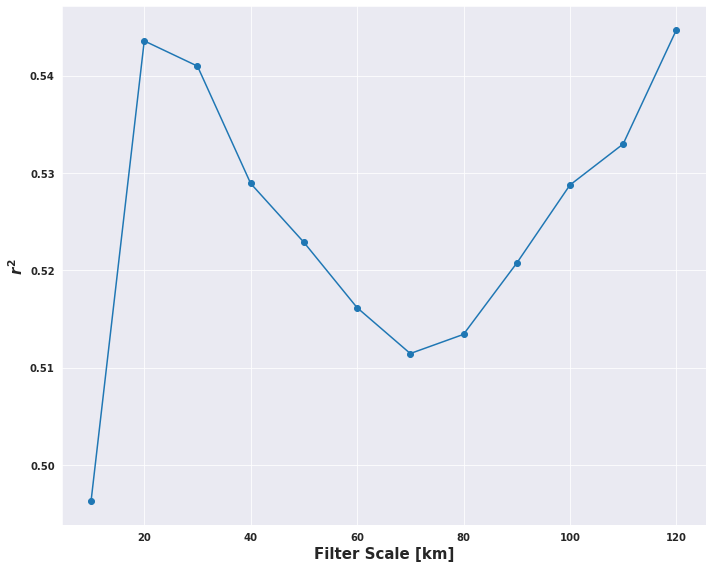

In [18]:
plt.figure(figsize=(10,8))
plt.plot(scales,corrs,'o-')
plt.xlabel('Filter Scale [km]',fontsize=15,fontweight='bold')
plt.ylabel(r'$r^{2}$',fontsize=15,fontweight='bold')

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/correlations_vs_scales2.png')



## Filtering SST and wind to find the $\gamma$ coefficient

In [20]:
usf=varf.sustr.groupby("time_counter.dayofyear").mean()
usf=usf.chunk(chunks=chunks_new);
usf=usf.compute();

# ust=vart.sustr.groupby("time_counter.dayofyear").mean()
# ust=ust.chunk(chunks=chunks_new);
# ust=ust.compute();


vsf=varf.svstr.groupby("time_counter.dayofyear").mean()
vsf=vsf.chunk(chunks=chunks_new);
vsf=vsf.compute();

# vst=vart.svstr.groupby("time_counter.dayofyear").mean()
# vst=vst.chunk(chunks=chunks_new);
# vst=vst.compute();



usf,vsf,_=romspickle.uvw2rho_3d(usf,vsf,usf)
# ust,vst,_=romspickle.uvw2rho_3d(ust,vst,vst)

usf,vsf=usf[:,120:-120,120:800],vsf[:,120:-120,120:800]
# ust,vst=ust[:,120:-120,120:800],vst[:,120:-120,120:800]

In [21]:
wsf=usf.copy()
wsf.data=np.sqrt(usf.data**2 + vsf.data**2)

In [23]:
dec=10
tf_band=tophat_bandpass_2d(tf[::dec],lowcut=45,highcut=1)
# tt_band=tophat_bandpass_2d(tt[::dec],lowcut=45,highcut=1)

wsf_band=tophat_bandpass_2d(wsf[::dec],lowcut=45,highcut=1)
# ht_band=tophat_bandpass_2d(ht[::dec],lowcut=45,highcut=1)




IOStream.flush timed out


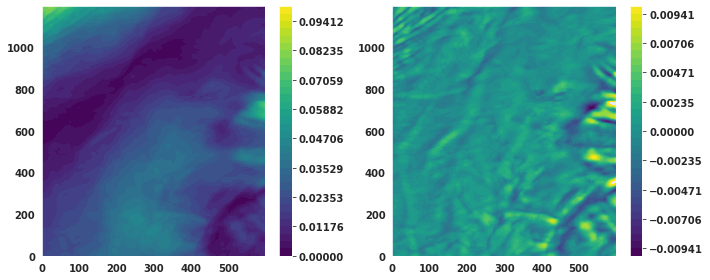

In [92]:
xlim=40


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.contourf(wsf[0,xlim:-xlim,xlim:-xlim],cmap='viridis',levels=np.linspace(0,0.1,35))
plt.colorbar()


plt.subplot(1,2,2)
plt.contourf(wsf_band[0,xlim:-xlim,xlim:-xlim],cmap='viridis',levels=np.linspace(-0.01,0.01,35))
plt.colorbar()

plt.tight_layout()

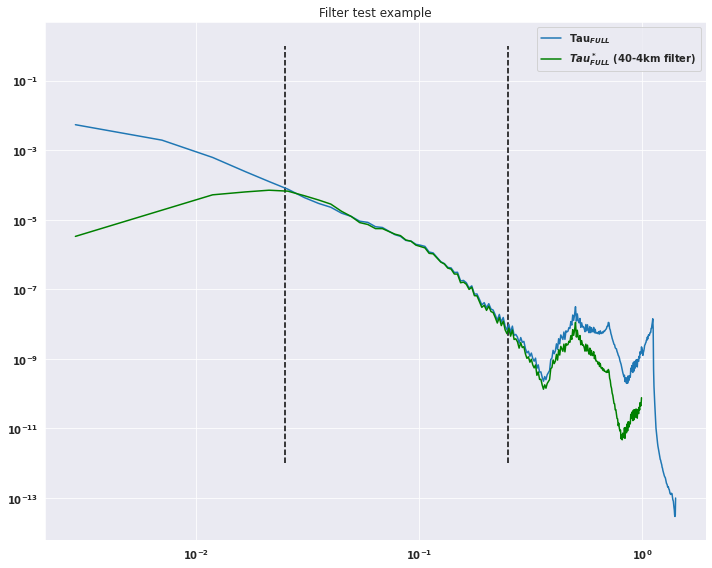

In [93]:
xlim=40
asp=xrft.isotropic_power_spectrum(wsf[::dec,xlim:-xlim,xlim:-xlim],dim=['x_u','y_u'],nfactor=2,dimtruncate='True',detrend='linear', window=True)
bsp=xrft.isotropic_power_spectrum(wsf_band[:,xlim:-xlim,xlim:-xlim],dim=['x_u','y_u'],nfactor=2,truncate='True',detrend='linear', window=True)



plt.figure(figsize=(10,8))
plt.plot([1/40,1/40],[1e-12,1],'k--')
plt.plot([1/4,1/4],[1e-12,1],'k--')


# plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

plt.title('Filter test example')
plt.plot(asp.freq_r/dxx,asp.mean(axis=0),label=r'Tau$_{FULL}$')
plt.plot(bsp.freq_r/dxx,bsp.mean(axis=0),color='green',label=r'$Tau^*_{FULL}$ (40-4km filter)')




plt.legend()

plt.yscale('log')
plt.xscale('log')

# plt.ylim(1e-10,1)
plt.tight_layout()

In [94]:
ddec=1
reg_f=pd.DataFrame({'SST':np.ravel(tf_band[:,xlim:-xlim,xlim:-xlim])[::ddec],'Tau':np.ravel(wsf_band[:,xlim:-xlim,xlim:-xlim])[::ddec]})
# reg_fbar=pd.DataFrame({'HFX':np.ravel(h_fg)[::100],'SST':np.ravel(sst_fg)[::100]})




In [95]:
np.corrcoef(reg_f.SST,reg_f.Tau)

array([[1.        , 0.46675387],
       [0.46675387, 1.        ]])

In [96]:
Rsq=np.zeros([wsf_band.shape[0]])*np.nan;

for icc in range(Rsq.shape[0]):
    Rsq[icc]=np.corrcoef(np.ravel(tf_band[icc,xlim:-xlim,xlim:-xlim]),np.ravel(wsf_band[icc,xlim:-xlim,xlim:-xlim]))[0][1]
    # Rsqm[icc]=np.corrcoef(np.ravel(r[icc]),np.ravel(h_fg[icc]))[0][1]



In [97]:
np.corrcoef(reg_f.SST,reg_f.Tau)[0][1]

0.4667538669977552

In [98]:
np.nanmean(Rsq)

0.4565212541560371

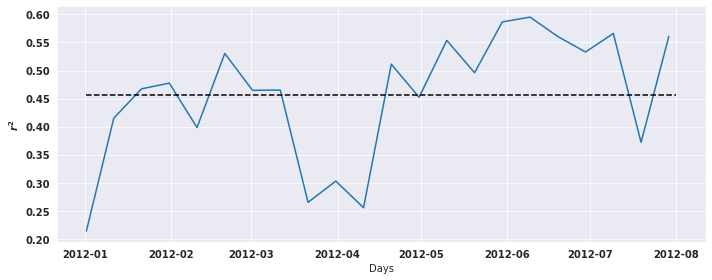

In [99]:
plt.figure(figsize=(10,4))

plt.plot(timer[::dec],Rsq)
plt.plot(timer,np.nanmean(Rsq)+np.zeros(timer.shape),'k--',color='black')
plt.ylabel(r'$r^{2}$')
plt.xlabel('Days')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/correlation_timeseries_SSTxWindstress_tophat.png')




In [100]:
apoly=np.zeros(wsf_band.shape[0])*np.nan;
bpoly=np.zeros(wsf_band.shape[0])*np.nan;
for ide in range(wsf_band.shape[0]):
    decx=1
    regg=pd.DataFrame({'SST':np.ravel(tf_band[ide,xlim:-xlim,xlim:-xlim])[::decx],'Tau':np.ravel(wsf_band[ide,xlim:-xlim,xlim:-xlim])[::decx]})
    apoly[ide],bpoly[ide]=np.polyfit(regg.SST,regg.Tau,deg=1)



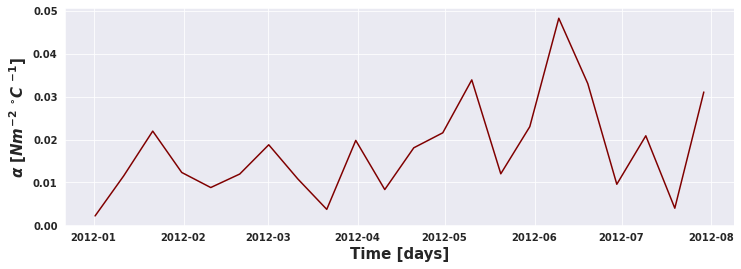

In [107]:

plt.figure(figsize=(12,4))
plt.plot(timer[::dec],apoly,color='maroon')
plt.xlabel('Time [days]',fontsize=15,fontweight='bold')
plt.ylabel(r'$\alpha$ $[N m^{-2}$ $^{\circ}C$ $^{-1}]$',fontsize=15,fontweight='bold')
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/slope_timeseries_SSTxWindstress_tophat.png')





In [56]:
aa,bb=np.polyfit(reg_f.SST,reg_f.Tau,deg=1)

In [104]:
aa

0.009668664830090715

In [105]:
np.nanmean(apoly)

0.017529891469346512

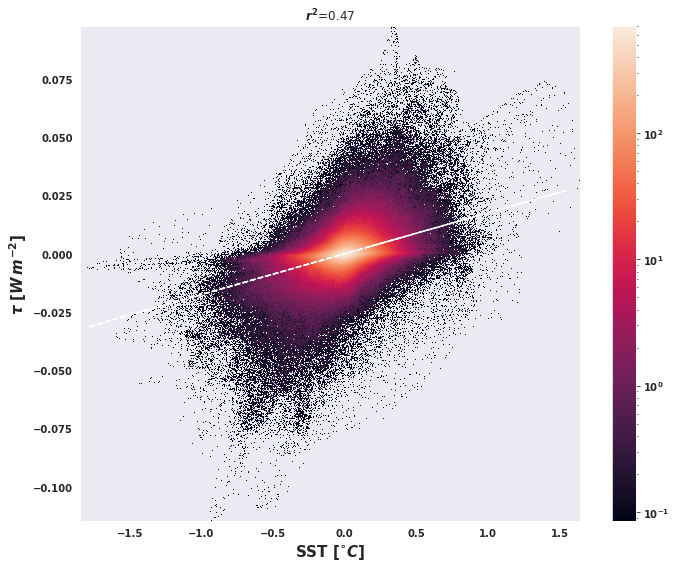

In [109]:
import matplotlib as mpl

plt.figure(figsize=(10,8))
plt.hist2d(reg_f.SST,reg_f.Tau,bins=1000,density=True,norm=mpl.colors.LogNorm())
# plt.hist2d(reg_fbar.SST,reg_fbar.HFX,bins=1000)
# plt.plot(reg_f.SST[::dec],(aa*reg_f.SST)[::dec],'w--',alpha=1)
plt.plot(reg_f.SST[::dec],(np.nanmean(apoly)*reg_f.SST)[::dec],'w--',alpha=1)



# plt.xlim(-2,2)
# plt.ylim(-60,60)
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$\tau$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.title(r'$r^{2}$'+'={0:.2f}'.format(np.corrcoef(reg_f.SST,reg_f.Tau)[0][1]))
# plt.grid(color='w')



plt.colorbar()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/CROCO_surface/regressions/2d_histogram_SSTxWindstress_tophat.png')
# 

